In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import utils as utils
from fractions import Fraction
from func import Func
import func

from IPython.display import display, HTML

# Inline plotting
%matplotlib inline

# Make sympy print pretty math expressions
sy.init_printing()

utils.load_custom_styles()


# Exercise 1 a) 


<img src="figures/sol-ex1a.jpg" width="500" />


# Exercise 1 b)

Using following procedure:

**Step 1:** Convert inequalities to equalites using slack variables

**Step 2:** Convert objective function to an equally.

**Step 3:** Construct the initial simplex tableaux


<img src="figures/sol-ex1b.jpg" width="500" />




**Step 4:** Find the pivot column by looking at the smallest value at the bottom row. 

**Step 5:** Find the pivot row by pick the smallest of the ratios: $b_i / a_{i1}$

**Step 6:** Make the pivot column to a basis column using elementary row operations.

Following row operations are needed:

- $R_1  - 2R_3 \to R_1$
- $R_2  - R_3 \to R_2$
- $R_4  + 3 R_3 \to R_4$


We can find the maximum using SciPy:

In [3]:
import linprog as lp

A = [[2, 1],
     [1, 1],
     [1, 0]]
b = [100, 80, 40]
c = [3, 2]

res = lp.maximise(A, b, c)
lp.pretty_print(res)

<IPython.core.display.Math object>

The maximum for $f(20, 60)=180$ 

# Exercise 1 c)

Moving the right hand side of inequality (i) would increase the maximum slightly. This is because of the following reasons.

We know that at least one of the extreme points or corners of the feasible area corresponds to an optimal solution according to Theorem 6:

<img src="figures/exam-jan-2018/theorem-6.png" width="800" />

This corresponds with the result in b). The maximum $(20, 60)$ is the intersection between (i) and (ii). 

Drawing the level set $f(x_1, x_2)=180$, it becomes clear why the line corresponding to inequality (i) should be moved.

# Exercise 2 a)

The gradient of $g$ gives the partial derivatives in each dimensions. The partial derivative $\frac{\partial g}{\partial x_1}$ gives us the slope of $g$ in the positive $x_1$ direction, $\frac{\partial f}{\partial x_2}$ gives us the slope of $g$ in the positive $x_2$ direction and $\frac{\partial g}{\partial x_3}$ gives us the slope in the positive $x_3$ direction.

Instead of fixing the direction, we can generalise the partial derivatives to compute the slope in any direction that we want. Like the partial derivative, we can define the directional derivative as follows:

\begin{align*}
D_{\mathbf{d}} f(\mathbf{x}) = \lim_{h \to 0} \frac{g(\mathbf{x} + h \mathbf{d}) - g(\mathbf{x})}{h}
\end{align*}

The directional derivative:
$$
\frac{\partial f(\mathbf{x})}{\partial \mathbf{d}} = \nabla f(\mathbf{x})^T \mathbf{d}
$$

In [12]:
x1,x2 = sy.symbols('x1, x2')
g = sy.exp((x1+1)*x2)
g

We can find the derivative using NumPy:

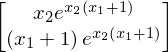

In [8]:
D = sy.Matrix([g]).jacobian((x1, x2)).T
D

Next, we find the directional derivative in the direction $d=[1,1]$:

In [14]:
dd = D.T * sy.Matrix([1, 1])
dd

Finally, we evaluate the directional derivative in the point (2,3):

In [15]:
dd.evalf(subs={x1:2, x2:3})

# Exercise 2 b)

We can use multivariable Taylor series:

$$
f(x) \approx f(x_0) + Df(x_0) (x-x_0) +  \frac{1}{2} (x-x_0)^T D^2 f(x_0) (x-x_0) + \dots
$$

In [63]:
x1,x2 = sy.symbols('x1, x2')
g = sy.exp((x1+1)*x2)
G = Func(g, (x1, x2))
G

In [64]:
def taylor(self, x0):
    """
    Computes the third order Taylor series expansion about the
    given point x0.
    """
    # Compute the vector: x-x0 since we are going to use multiple times
    x_minus_x0  = self._x - sy.Matrix(x0)

    # Compute f(x0)
    term1 = self.func_at(x0)

    # Compute dfdx(x0)*(x-x0)
    term2 = self.gradient_at(x0).T * x_minus_x0

    # Compute p1 = 1/2*(x-x0)
    p1 = sy.Rational(1, 2) * x_minus_x0

    # Compute p2 = p1^T * Hessian(x0)
    p2 = p1.T * self.hessian_at(x0)

    # Compute term3 = p2 * (x-x0)
    term3 = p2 * x_minus_x0

    result = term1 + term2 + term3

    # Simplify the sum of all the terms
    # return sy.simplify(result)
    return result

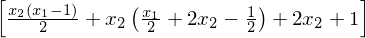

In [65]:
result = taylor(G, (1, 0))
result

In [66]:
sy.simplify(result)

# Exercise 2 c)

Since it is an optimisation problem with equality constraints, we can use the Lagrangian method.

The Lagrangian method is given as follows:
1. Define the Lagrangian function by incoporating the constraint into the objective function
$$
L(\mathbf{x}, \lambda) = f(\mathbf{x}) - \lambda ( h(\mathbf{x}) - c  )
$$
where $\lambda$ is the Lagrangian multiplier associated with the contraint. When the contraint holds i.e., when $h(\mathbf{x})=c$ then $L(\mathbf{x}, \lambda)=f(\mathbf{x})$
2. Since $L(\mathbf{x}, \lambda)$ is an unconstraint objective function, we can optimise it by finding its FONC i.e., taking the derivative and setting it zero.
3. Now, we get a system of linear equations. Solving it will yield the points where the objective function is maximised or minimised.

In [19]:
x1, x2 = sy.symbols('x1, x2')
f = (x1 - 1)**2 + x2**2
h = Fraction(1,9)*x1**2 + Fraction(1,4)*x2**2 - 1
F = Func(f, (x1, x2), constraints=[h])
F

In [22]:
def solve_lagrangian(self):
    num_constraints = len(self._constraints)

    # Define a lambda symbol for each constraint
    lambda_names = tuple([('lambda%s' % i) for i in range(1, num_constraints+1)])
    lambdas = sy.symbols(lambda_names)
    lambda_vec = sy.Matrix(lambdas)

    # Define constraints as vector
    H = sy.Matrix(self._constraints)

    # Formulate the Lagrangian function l
    l = self._f - lambda_vec.T * H

    # Find the gradient of the Lagrangian function
    # with respect to all parameters
    all_params = tuple(self._x) + lambdas
    Dl = l.jacobian(all_params)

    # Solve it with respect to all the parameters
    result = sy.nonlinsolve(Dl, all_params)

    # Remove the lambda value from the results
    points = [tup[0:-num_constraints] for tup in list(result)]
    lambdas = [tup[-num_constraints:] for tup in list(result)]

    return points, lambdas

In [25]:
points, lambdas = solve_lagrangian(F)

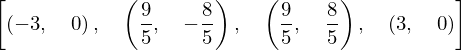

In [26]:
points

In [27]:
F.evalf(points)

Evaluting f(-3, 0) = 16.0000000000000
Evaluting f(9/5, -8/5) = 3.20000000000000
Evaluting f(9/5, 8/5) = 3.20000000000000
Evaluting f(3, 0) = 4.00000000000000


The maximum is $(-3, 0)$ and the minimum point are $(9/5, -8/5)$ and $(9/5, 8/5)$.

# Exercise 3 a)

We can stop when we reach maximum number of iterations e.g. 1000, or stop when the current position does not change much.

# Exercise 3 b)

Because this is the mechanism for which the algorithm attempts to escape local minima.

# Exercise 3 c)

When the input to the objective function is discrete then we have a discrete optimisation otherwise we have a continuous optimisation.

# Exercise 3 d)

No

# Exercise 3 e. i)

A candidate solution is path that can be represented as an array of locations e.g. [A, B, C, D, E, F].

# Exercise 3 e. ii)

If we represent the problem as a graph, the neighbour algorithm could find the set of locations that have edges to a given location.

# Exercise 3 e. iii)

# Exercise 3 e. iv)

# Exercise 3 e. v)

Simulated annealing is more likely to accept worse candidate solution when the temperature is hot i.e. at the beginning of the algorithm. As the iteration index $k$ increases, the algorithm becomes increasingly reluctant to choose to a worse point. 

# Exercise 3 e. vi)

# Exercise 4 a)

In [32]:
C1 = np.array([[1, 1],
               [2, 0]])
C2 = np.array([[ 0, -2],
               [-1, -1]])
X_test = np.array([[ 2,  0, -1, -2],
                   [ 0,  0,  1,  0]])

In [33]:
from sklearn.metrics.pairwise import pairwise_distances

# Compute the class centroid for each class
mu1 = np.mean(C1, axis=1).reshape(-1, 1)
mu2 = np.mean(C2, axis=1).reshape(-1, 1)

# Compute distances between the centroids and the test samples
pair_dist_mu1 = pairwise_distances(X_test.T, mu1.T)
pair_dist_mu2 = pairwise_distances(X_test.T, mu2.T)
pair_dist = np.concatenate([pair_dist_mu1, pair_dist_mu2], axis=1)

# Classify using the lowest distance
np.argmin(pair_dist, axis=1)+1

array([1, 1, 1, 2])

$x_5, x_6$ and $x_7$ is classified to class 1 and $x_8$ is classified to class 2.

# Exercise 4 b)

In [39]:
X = np.concatenate([C1, C2], axis=1)
l = [1, 1, 2, 2]

In [40]:
classifications = []
for i in range(X_test.shape[1]):
    x_i = X_test[:,i].reshape(-1, 1)
    # Compute the distance each sample in the training set
    pair_dist = pairwise_distances(X.T, x_i.T).reshape(-1)
    
    # Assign the label of the closest sample
    index = np.argmin(pair_dist, axis=0)
    label = l[index]
    
    classifications.append(label)
classifications

$x_5, x_6$ and $x_7$ is classified to class 1 and $x_8$ is classified to class 2.

# Exercise 4 c)

The optimal projection vector $\mathbf{w}$ can be computed as follows:

<img src="figures/lecture-19/fisher-ratio-solution-2b.png" width="600" />


The within-class scatter matrix $\mathbf{S}_w$ can be computed as follows:

<img src="figures/lecture-19/within-scatter-matrix-formula.png" width="600" />








In [43]:
m1 = np.mean(C1, axis=1).reshape(-1, 1)
m2 = np.mean(C2, axis=1).reshape(-1, 1)

S1 = np.dot((C1 - m1), (C1 - m1).T)
S2 = np.dot((C2 - m2), (C2 - m2).T)
Sw = S1 + S2
Sw

array([[2, 0],
       [0, 2]])

In [45]:
w = np.dot(np.linalg.inv(Sw), m1-m2)
w = w.reshape(-1)
w

array([1, 1])

The projection vector is $\mathbf{w}=[1, 1]^T$.

# Exercise 4 d)

<img src="figures/sol-ex-4d.png" width="400" />



# Exercise 5 a)

We can use Baye's decision rule to classify the test samples:

- Classify $x$ as $c_1$ if $P(c_1 \mid x) > P(c_2 \mid x)$; otherwise classify $x$ as $c_2$

Using Bayes' formula, we have:

$$
P(c_k \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid c_k) P(c_k)}{p(\mathbf{x})}
$$
where
$$
p(\mathbf{x}) = \sum_{k=1}^K p(\mathbf{x} \mid c_k) P(c_k)
$$

Since $p(\mathbf{x})$ is the same for when computing $P(c_k\mid \mathbf{x})$, it is not necessary to compute it when we want to use the conditional probability to classify new samples. Therefore, the decision rule becomes:

- Classify $x$ as $c_1$ if $p(x \mid c_1)P(c_1) \geq p(x \mid c_2) P (c_2)$; otherwise classify $x$ as $c_2$

The prior probabilities $P(c_1)$ and $P(c_2)$ are given:
- $P(c_1) = 500/1500=1/3$
- $P(c_2) = 1000/1500=2/3$


In [47]:
P_c1 = 1/3
P_c2 = 2/2

In [48]:
p_x_c1 = np.array([0.2, 0.1, 0.05, 0])
p_x_c2 = np.array([0, 0.05, 0.1, 0.2])

In [49]:
P_c1_x = p_x_c1 * P_c1
P_c1_x

array([1/15, 1/30, 1/60, 0])

In [50]:
P_c2_x = p_x_c2 * P_c2
P_c2_x

array([0, 1/20, 1/10, 1/5])

In [51]:
# Create a matrix so we can easily compute argmin
P_ck_x = np.concatenate([[P_c1_x], 
                         [P_c2_x]])
P_ck_x

array([[1/15, 1/30, 1/60, 0],
       [0, 1/20, 1/10, 1/5]])

In [56]:
def print_classification(P, objective='max'):
    labels = np.argmin(P, axis=0)+1 if objective=='min' else np.argmax(P, axis=0)+1
    out = 'Classification Result: \n$$\n'
    for i, label in enumerate(labels):
        out += 'x_{} \\to c_{}  \\\\ \n'.format(i+1, label)
    #['x{} => c{}'.format(i+1, label) for i, label in enumerate(labels)]
    out += '$$'
    return HTML(out)

In [57]:
print_classification(P_ck_x, objective='max')

# Exercise 5 b)

In [58]:
Lambda = np.array([[  0, 0.4],
                   [0.3,   0]])

In [59]:
n_classes = len(P_ck_x)
n_actions = Lambda.shape[1]
R_ai_x = []
for i in range(n_actions):
    lambda_i = Lambda[i,:]
    R_ai_x.append(0.0)
    for k in range(n_classes):
        R_ai_x[i] += lambda_i[k] * P_ck_x[k]
R_ai_x

[array([0, 1/50, 1/25, 2/25]), array([1/50, 1/100, 1/200, 0])]

In [60]:
print_classification(R_ai_x, objective='min')

# Exercise 6 a)

No, because the samples in each class in the projected space would be mixed together and therefore difficult to discriminate.

# Exercise 6 b)

In order to classify the test samples using a linear classifier, we can augment the data representations using a mapping that transforms the original samples to another feature space where the samples become linearly separable.

We can use the second order polynomial kernel function:

$$
\phi(\mathbf{x}) = 
\begin{bmatrix}
x_1^2 \\
\sqrt{2} x_1 x_2 \\
x_2^2 
\end{bmatrix}
$$

The decision function in the original feature space:

<img src="figures/sol-ex-6a.png" width="400" />


The decision function in the transformed space would be a 2D plane that looks something like the grey plane in the figure below:



<img src="figures/exam-jun-2018/sol-ex4.2.b.png" width="200" />





# Exercise 6 c)

<img src="figures/sol-ex-6c.jpg" width="600" />


We cannot use a linear activation function in the hidden layer. To simplify the proof, we ignore the bias terms. Suppose we have a three-layer network (one hidden layer and one output neuron). The output neuron is computed:

$$
o_{ML} = \mathbf{w}^{(2)T} \mathbf{h}_1
$$

The $\mathbf{h}_1$ is computed as follows:

$$
\mathbf{h}_1 = \mathbf{W}^{(1)T} \mathbf{x}
$$

Combining the expressions, we get:

$$
o_{3L} = \mathbf{w}^{(2)T} \mathbf{W}^{(1)T} \mathbf{x}
$$

The expression above can be simplied:
$$
o_{3L} = \mathbf{w}^T_{c} \mathbf{x}
$$
where $\mathbf{w}_{c} = \mathbf{w}^{(2)T} \mathbf{W}^{(1)T}$

This expression is linear discriminant function which means that the three-layer network will not be able to handle samples that are not linearly separable when the activation functions for all neurons are linear.

A neural network that only uses linear activation functions cannot model a nonlinear function even though the network consists of large number of hidden layers and neurons. Therefore, non-linear activation functions are important in the neural network for this task because the samples are not linearly separable.